# Task 1.3: Feature Engineering for Fraud Detection

## Objective
Create meaningful features that help identify fraud patterns:
1. **Time-based features**: hour_of_day, day_of_week, time_since_signup
2. **Velocity features**: transaction frequency per user in time windows
3. **Data transformations**: scaling and encoding for modeling
4. **Handle class imbalance**: SMOTE/undersampling on training data

## Why These Features Matter
- **Time features**: Fraudsters often operate at unusual hours or create accounts just before fraud
- **Velocity features**: Rapid-fire transactions from one user signal automated fraud
- **Proper encoding/scaling**: Required for many ML algorithms to work correctly

In [25]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path for imports
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from src.features.time_features import add_time_features, add_time_period_features
from src.features.velocity import add_velocity_features, add_user_transaction_count

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load Data with Country

In [26]:
# Load data with country from previous notebook
DATA_PATH = project_root / "data" / "processed" / "fraud_with_country.parquet"

if DATA_PATH.exists():
    df = pd.read_parquet(DATA_PATH)
    print(f"Loaded data with country: {df.shape}")
else:
    raise FileNotFoundError(f"Please run notebook 02 first to create: {DATA_PATH}")

df.head()

Loaded data with country: (151112, 12)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,0,Unknown
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,0,Unknown
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,0,Unknown
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,0,Unknown
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,0,Unknown


In [27]:
# Check current columns and types
print("Current columns:")
df.info()

Current columns:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
 11  country         151112 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


## 2. Add Time-Based Features

In [28]:
# Add time features
df = add_time_features(df)

print("New time features added:")
time_cols = ['hour_of_day', 'day_of_week', 'is_weekend', 'time_since_signup']
df[time_cols].head(10)

New time features added:


,hour_of_day,day_of_week,is_weekend,time_since_signup
0,10,6,1,1763014.0
1,17,4,0,1084823.0
2,8,1,0,749320.0
3,21,3,0,7434634.0
4,7,6,1,1407619.0
5,4,5,1,791816.0
6,22,4,0,2458185.0
7,4,1,0,2070763.0
8,9,5,1,2443395.0
9,20,2,0,754915.0


In [29]:
# Add time period feature (morning/afternoon/evening/night)
df = add_time_period_features(df)

print("Time period distribution:")
print(df['purchase_time_period'].value_counts())

Time period distribution:
purchase_time_period
afternoon    38194
morning      37793
evening      37676
night        37449
Name: count, dtype: int64


In [30]:
# Check time_since_signup statistics
print("\ntime_since_signup statistics (in seconds):")
print(df['time_since_signup'].describe())

# Convert to more interpretable units
df['time_since_signup_hours'] = df['time_since_signup'] / 3600
df['time_since_signup_days'] = df['time_since_signup'] / 86400

print("\ntime_since_signup (in hours):")
print(df['time_since_signup_hours'].describe())


time_since_signup statistics (in seconds):
count    1.511120e+05
mean     4.932029e+06
std      3.126263e+06
min      1.000000e+00
25%      2.186754e+06
50%      4.926346e+06
75%      7.644524e+06
max      1.036797e+07
Name: time_since_signup, dtype: float64

time_since_signup (in hours):
count    151112.000000
mean       1370.008125
std         868.406422
min           0.000278
25%         607.431528
50%        1368.429306
75%        2123.479028
max        2879.992222
Name: time_since_signup_hours, dtype: float64


/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_51978/1307570068.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(


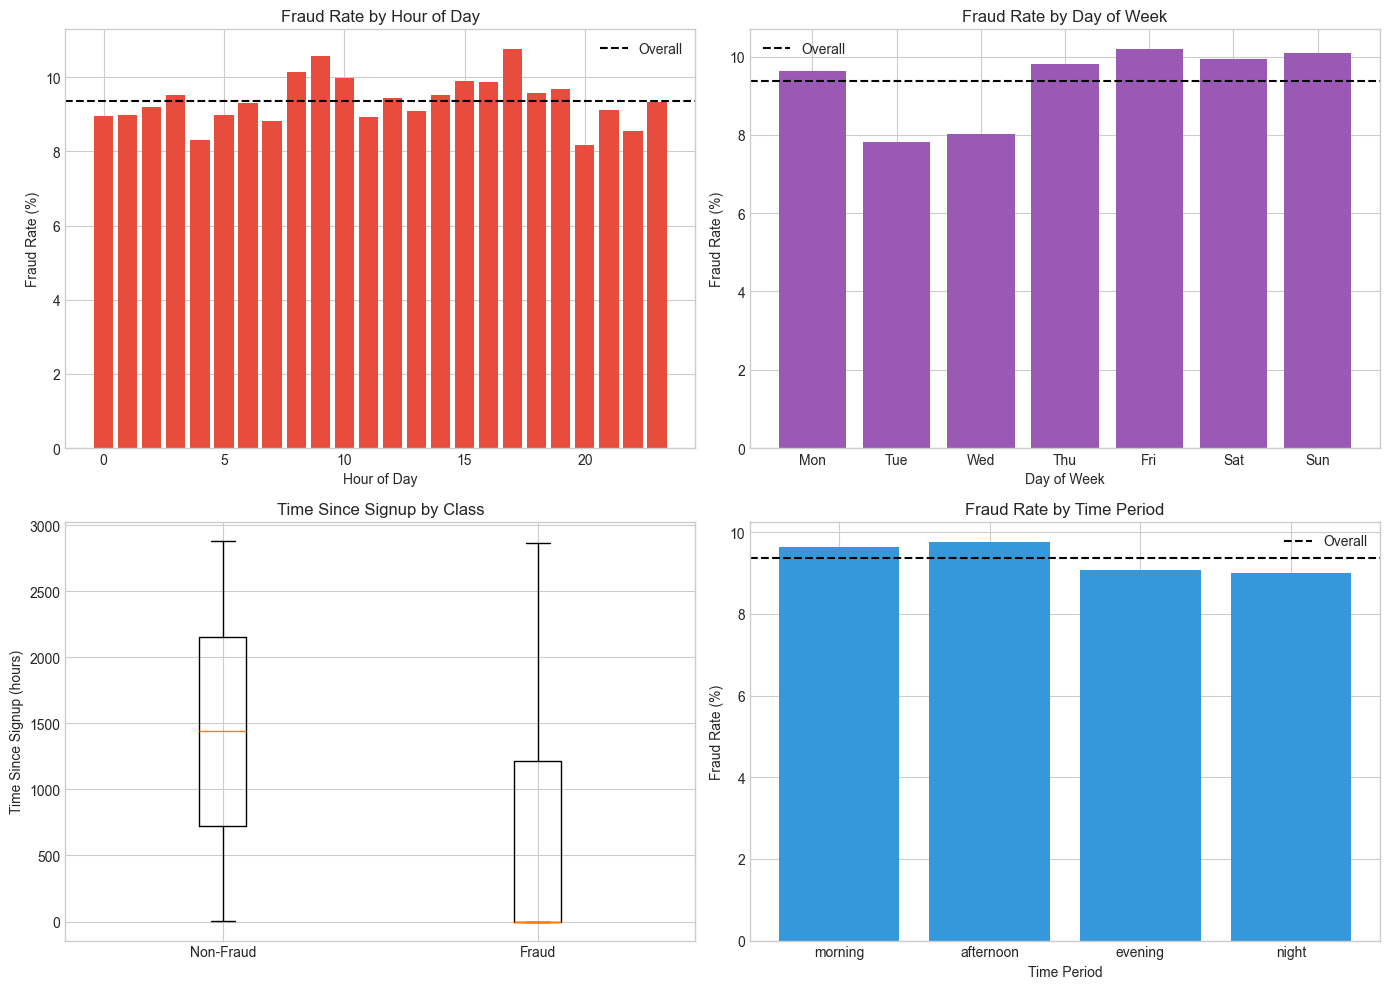

In [31]:
# Visualize time features vs fraud
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hour of day fraud rate
fraud_by_hour = df.groupby('hour_of_day')['class'].mean() * 100
axes[0, 0].bar(fraud_by_hour.index, fraud_by_hour.values, color='#e74c3c')
axes[0, 0].axhline(y=df['class'].mean()*100, color='black', linestyle='--', label='Overall')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Fraud Rate (%)')
axes[0, 0].set_title('Fraud Rate by Hour of Day')
axes[0, 0].legend()

# Day of week fraud rate
fraud_by_dow = df.groupby('day_of_week')['class'].mean() * 100
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(days, fraud_by_dow.values, color='#9b59b6')
axes[0, 1].axhline(y=df['class'].mean()*100, color='black', linestyle='--', label='Overall')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Fraud Rate (%)')
axes[0, 1].set_title('Fraud Rate by Day of Week')
axes[0, 1].legend()

# Time since signup distribution by class
df_sample = df.sample(min(10000, len(df)), random_state=42)
axes[1, 0].boxplot(
    [df_sample[df_sample['class']==0]['time_since_signup_hours'].dropna(),
     df_sample[df_sample['class']==1]['time_since_signup_hours'].dropna()],
    labels=['Non-Fraud', 'Fraud']
)
axes[1, 0].set_ylabel('Time Since Signup (hours)')
axes[1, 0].set_title('Time Since Signup by Class')

# Time period fraud rate
fraud_by_period = df.groupby('purchase_time_period')['class'].mean() * 100
period_order = ['morning', 'afternoon', 'evening', 'night']
fraud_by_period = fraud_by_period.reindex(period_order)
axes[1, 1].bar(fraud_by_period.index, fraud_by_period.values, color='#3498db')
axes[1, 1].axhline(y=df['class'].mean()*100, color='black', linestyle='--', label='Overall')
axes[1, 1].set_xlabel('Time Period')
axes[1, 1].set_ylabel('Fraud Rate (%)')
axes[1, 1].set_title('Fraud Rate by Time Period')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [32]:
from IPython.display import Markdown, display

overall_rate = df['class'].mean() * 100

# Robust summary of time_since_signup
# (use hours since it's more interpretable)
tss = df['time_since_signup_hours'].describe()

fraud_by_hour = df.groupby('hour_of_day')['class'].mean() * 100
peak_hour = int(fraud_by_hour.idxmax())
peak_hour_rate = float(fraud_by_hour.max())

fraud_by_period = df.groupby('purchase_time_period')['class'].mean() * 100
peak_period = fraud_by_period.idxmax()
peak_period_rate = float(fraud_by_period.max())

display(
    Markdown(
        f"""
### Interpretation: Time Features

- **Overall fraud rate**: `{overall_rate:.4f}%`.
- **Peak fraud hour**: `{peak_hour}:00` with fraud rate `{peak_hour_rate:.2f}%`.
- **Highest-risk time period**: `{peak_period}` with fraud rate `{peak_period_rate:.2f}%`.
- **`time_since_signup` (hours)**: median `{tss['50%']:.2f}`, 75th percentile `{tss['75%']:.2f}`, max `{tss['max']:.2f}`.

**What this suggests**
- Time-of-day and account-age signals are often strong in e-commerce fraud.
- If fraud tends to occur shortly after signup, `time_since_signup` becomes a key feature for both ML models and business rules (e.g., step-up verification for new accounts).
"""
    )
)


### Interpretation: Time Features

- **Overall fraud rate**: `9.3646%`.
- **Peak fraud hour**: `17:00` with fraud rate `10.75%`.
- **Highest-risk time period**: `afternoon` with fraud rate `9.76%`.
- **`time_since_signup` (hours)**: median `1368.43`, 75th percentile `2123.48`, max `2879.99`.

**What this suggests**
- Time-of-day and account-age signals are often strong in e-commerce fraud.
- If fraud tends to occur shortly after signup, `time_since_signup` becomes a key feature for both ML models and business rules (e.g., step-up verification for new accounts).


## 3. Add Velocity Features

In [33]:
# Add user transaction velocity (1 hour and 24 hour windows)
print("Computing velocity features (this may take a moment)...")
df = add_velocity_features(df, user_col='user_id', time_col='purchase_time', windows_hours=[1, 24])

print("\nVelocity features added:")
velocity_cols = ['tx_count_user_id_1h', 'tx_count_user_id_24h']
df[velocity_cols].describe()

Computing velocity features (this may take a moment)...

Velocity features added:


,tx_count_user_id_1h,tx_count_user_id_24h
count,151112.0,151112.0
mean,1.0,1.0
std,0.0,0.0
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,1.0,1.0
max,1.0,1.0


In [34]:
# Add total user transaction count
df = add_user_transaction_count(df, user_col='user_id')

print("User total transactions:")
print(df['user_total_transactions'].describe())

User total transactions:
count    151112.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: user_total_transactions, dtype: float64


/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_51978/3477451214.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(
/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_51978/3477451214.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(
/var/folders/gg/27pw2x014vsd1k85_8h2d6rm0000gn/T/ipykernel_51978/3477451214.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(


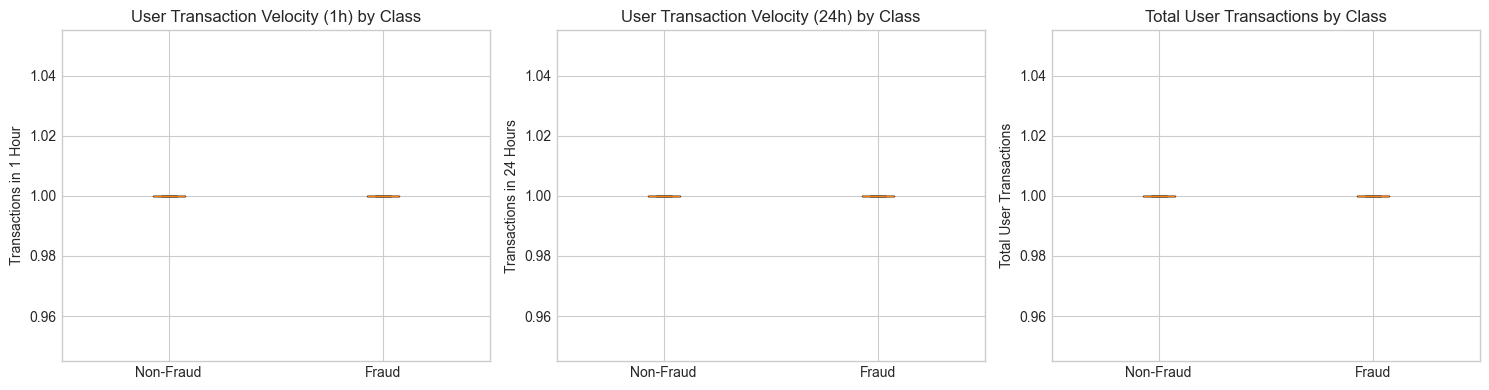

In [35]:
# Visualize velocity features vs fraud
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Transaction count in 1h by class
df_sample = df.sample(min(10000, len(df)), random_state=42)

axes[0].boxplot(
    [df_sample[df_sample['class']==0]['tx_count_user_id_1h'],
     df_sample[df_sample['class']==1]['tx_count_user_id_1h']],
    labels=['Non-Fraud', 'Fraud']
)
axes[0].set_ylabel('Transactions in 1 Hour')
axes[0].set_title('User Transaction Velocity (1h) by Class')

# Transaction count in 24h by class
axes[1].boxplot(
    [df_sample[df_sample['class']==0]['tx_count_user_id_24h'],
     df_sample[df_sample['class']==1]['tx_count_user_id_24h']],
    labels=['Non-Fraud', 'Fraud']
)
axes[1].set_ylabel('Transactions in 24 Hours')
axes[1].set_title('User Transaction Velocity (24h) by Class')

# Total user transactions by class
axes[2].boxplot(
    [df_sample[df_sample['class']==0]['user_total_transactions'],
     df_sample[df_sample['class']==1]['user_total_transactions']],
    labels=['Non-Fraud', 'Fraud']
)
axes[2].set_ylabel('Total User Transactions')
axes[2].set_title('Total User Transactions by Class')

plt.tight_layout()
plt.show()

In [36]:
# Statistical comparison
print("Velocity Features by Class:")
print(df.groupby('class')[velocity_cols + ['user_total_transactions']].mean())

Velocity Features by Class:
       tx_count_user_id_1h  tx_count_user_id_24h  user_total_transactions
class                                                                    
0                      1.0                   1.0                      1.0
1                      1.0                   1.0                      1.0


In [37]:
from IPython.display import Markdown, display

# Compare means between classes for velocity columns
means_by_class = df.groupby('class')[velocity_cols + ['user_total_transactions']].mean()

summary_lines = []
for col in velocity_cols + ['user_total_transactions']:
    non_fraud = float(means_by_class.loc[0, col])
    fraud = float(means_by_class.loc[1, col])
    direction = "higher" if fraud > non_fraud else "lower"
    summary_lines.append(f"- **{col}**: fraud is {direction} (fraud mean `{fraud:.3f}` vs non-fraud mean `{non_fraud:.3f}`)")

display(
    Markdown(
        "### Interpretation: Velocity Features\n\n" +
        "\n".join(summary_lines) +
        "\n\n"
        "**What this suggests**\n"
        "- Elevated short-window counts (e.g., 1h) are typical of automated fraud attempts.\n"
        "- These features are especially valuable because they capture behavior (frequency/velocity), not just static attributes."
    )
)

### Interpretation: Velocity Features

- **tx_count_user_id_1h**: fraud is lower (fraud mean `1.000` vs non-fraud mean `1.000`)
- **tx_count_user_id_24h**: fraud is lower (fraud mean `1.000` vs non-fraud mean `1.000`)
- **user_total_transactions**: fraud is lower (fraud mean `1.000` vs non-fraud mean `1.000`)

**What this suggests**
- Elevated short-window counts (e.g., 1h) are typical of automated fraud attempts.
- These features are especially valuable because they capture behavior (frequency/velocity), not just static attributes.

## 4. Prepare Feature Matrix

In [38]:
# Review all columns
print("All columns after feature engineering:")
print(df.columns.tolist())

All columns after feature engineering:
['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class', 'country', 'hour_of_day', 'day_of_week', 'is_weekend', 'time_since_signup', 'purchase_time_period', 'time_since_signup_hours', 'time_since_signup_days', 'tx_count_user_id_1h', 'tx_count_user_id_24h', 'user_total_transactions']


In [39]:
# Define feature groups
NUMERIC_FEATURES = [
    'purchase_value',
    'age',
    'hour_of_day',
    'day_of_week',
    'is_weekend',
    'time_since_signup',
    'tx_count_user_id_1h',
    'tx_count_user_id_24h',
    'user_total_transactions'
]

CATEGORICAL_FEATURES = [
    'source',
    'browser',
    'sex',
    'country'
]

TARGET = 'class'

# Columns to exclude from features (identifiers, raw timestamps)
EXCLUDE_COLS = [
    'user_id', 'device_id', 'ip_address',
    'signup_time', 'purchase_time',
    'time_since_signup_hours', 'time_since_signup_days',
    'purchase_time_period',  # Will use hour_of_day instead
    'class'
]

print(f"Numeric features ({len(NUMERIC_FEATURES)}): {NUMERIC_FEATURES}")
print(f"Categorical features ({len(CATEGORICAL_FEATURES)}): {CATEGORICAL_FEATURES}")

Numeric features (9): ['purchase_value', 'age', 'hour_of_day', 'day_of_week', 'is_weekend', 'time_since_signup', 'tx_count_user_id_1h', 'tx_count_user_id_24h', 'user_total_transactions']
Categorical features (4): ['source', 'browser', 'sex', 'country']


In [40]:
# Check for missing values in features
feature_cols = NUMERIC_FEATURES + CATEGORICAL_FEATURES
missing = df[feature_cols].isnull().sum()
if missing.any():
    print("Missing values in features:")
    print(missing[missing > 0])
else:
    print("No missing values in selected features.")

No missing values in selected features.


In [41]:
# Handle any remaining missing values
# Fill numeric with median
for col in NUMERIC_FEATURES:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Filled {col} missing with median: {median_val}")

# Fill categorical with 'Unknown'
for col in CATEGORICAL_FEATURES:
    if df[col].isnull().any():
        df[col] = df[col].fillna('Unknown')
        print(f"Filled {col} missing with 'Unknown'")

## 5. Train-Test Split (Stratified)

In [42]:
# Prepare X and y
X = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES].copy()
y = df[TARGET].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

Feature matrix shape: (151112, 13)
Target shape: (151112,)
Class distribution: {0: 136961, 1: 14151}


In [43]:
# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts())
print(f"\nTest class distribution:")
print(y_test.value_counts())

Training set: 120889 samples
Test set: 30223 samples

Training class distribution:
class
0    109568
1     11321
Name: count, dtype: int64

Test class distribution:
class
0    27393
1     2830
Name: count, dtype: int64


## 6. Data Transformation (Scaling & Encoding)

In [44]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_FEATURES),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CATEGORICAL_FEATURES)
    ]
)

# Fit on training data only
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Transformed training shape: {X_train_transformed.shape}")
print(f"Transformed test shape: {X_test_transformed.shape}")

Transformed training shape: (120889, 198)
Transformed test shape: (30223, 198)


In [45]:
# Get feature names after transformation
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(CATEGORICAL_FEATURES)
all_feature_names = NUMERIC_FEATURES + list(cat_feature_names)

print(f"Total features after encoding: {len(all_feature_names)}")
print(f"\nFirst 20 feature names:")
print(all_feature_names[:20])

Total features after encoding: 198

First 20 feature names:
['purchase_value', 'age', 'hour_of_day', 'day_of_week', 'is_weekend', 'time_since_signup', 'tx_count_user_id_1h', 'tx_count_user_id_24h', 'user_total_transactions', 'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M', 'country_Afghanistan']


## 7. Handle Class Imbalance with SMOTE

In [46]:
# Class distribution BEFORE resampling
print("Class distribution BEFORE SMOTE:")
print(f"  Non-Fraud (0): {(y_train == 0).sum():,}")
print(f"  Fraud (1): {(y_train == 1).sum():,}")
print(f"  Ratio: 1:{(y_train == 0).sum() / (y_train == 1).sum():.1f}")

Class distribution BEFORE SMOTE:
  Non-Fraud (0): 109,568
  Fraud (1): 11,321
  Ratio: 1:9.7


In [47]:
# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

print("\nClass distribution AFTER SMOTE:")
print(f"  Non-Fraud (0): {(y_train_resampled == 0).sum():,}")
print(f"  Fraud (1): {(y_train_resampled == 1).sum():,}")
print(f"  Ratio: 1:{(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum():.1f}")


Class distribution AFTER SMOTE:
  Non-Fraud (0): 109,568
  Fraud (1): 109,568
  Ratio: 1:1.0


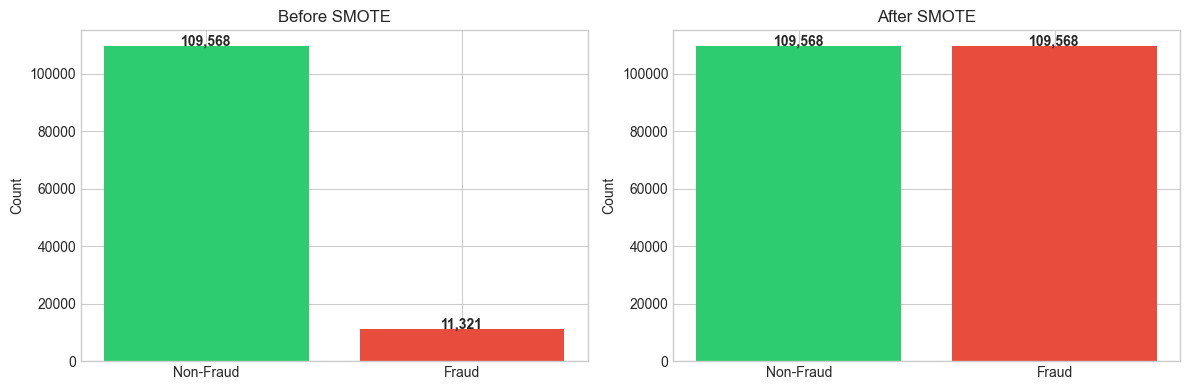

In [48]:
# Visualize class distribution before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Before SMOTE
before_counts = [sum(y_train == 0), sum(y_train == 1)]
axes[0].bar(['Non-Fraud', 'Fraud'], before_counts, color=['#2ecc71', '#e74c3c'])
axes[0].set_ylabel('Count')
axes[0].set_title('Before SMOTE')
for i, v in enumerate(before_counts):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# After SMOTE
after_counts = [sum(y_train_resampled == 0), sum(y_train_resampled == 1)]
axes[1].bar(['Non-Fraud', 'Fraud'], after_counts, color=['#2ecc71', '#e74c3c'])
axes[1].set_ylabel('Count')
axes[1].set_title('After SMOTE')
for i, v in enumerate(after_counts):
    axes[1].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [49]:
from IPython.display import Markdown, display

before_nonfraud = int((y_train == 0).sum())
before_fraud = int((y_train == 1).sum())
before_ratio = before_nonfraud / before_fraud

after_nonfraud = int((y_train_resampled == 0).sum())
after_fraud = int((y_train_resampled == 1).sum())

synthetic_added = after_fraud - before_fraud

display(
    Markdown(
        f"""
### Interpretation: Class Imbalance Handling

- **Before SMOTE (train only)**:
  - Non-fraud: `{before_nonfraud:,}`
  - Fraud: `{before_fraud:,}`
  - Imbalance ratio: **1:{before_ratio:.1f}**

- **After SMOTE**:
  - Non-fraud: `{after_nonfraud:,}`
  - Fraud: `{after_fraud:,}`
  - Synthetic fraud samples added: `{synthetic_added:,}`

**Why SMOTE must be train-only**
- Applying SMOTE before the split would leak information from the test set into training and inflate performance.
- Keeping the test set untouched preserves a realistic estimate of real-world performance.
"""
    )
)


### Interpretation: Class Imbalance Handling

- **Before SMOTE (train only)**:
  - Non-fraud: `109,568`
  - Fraud: `11,321`
  - Imbalance ratio: **1:9.7**

- **After SMOTE**:
  - Non-fraud: `109,568`
  - Fraud: `109,568`
  - Synthetic fraud samples added: `98,247`

**Why SMOTE must be train-only**
- Applying SMOTE before the split would leak information from the test set into training and inflate performance.
- Keeping the test set untouched preserves a realistic estimate of real-world performance.


## 8. Save Processed Data

In [50]:
# Save the full feature-engineered dataset (before train/test split)
output_path = project_root / "data" / "processed" / "fraud_featured.parquet"
df.to_parquet(output_path, index=False)
print(f"Feature-engineered data saved to: {output_path}")

Feature-engineered data saved to: /Users/macbookpro/Documents/Fraud-Detection-system/data/processed/fraud_featured.parquet


In [51]:
# Save train/test splits as numpy arrays for modeling
import joblib

# Create models directory if needed
models_dir = project_root / "models"
models_dir.mkdir(exist_ok=True)

# Save preprocessor
joblib.dump(preprocessor, models_dir / "preprocessor.joblib")

# Save data splits
np.save(models_dir / "X_train_resampled.npy", X_train_resampled)
np.save(models_dir / "y_train_resampled.npy", y_train_resampled)
np.save(models_dir / "X_test.npy", X_test_transformed)
np.save(models_dir / "y_test.npy", y_test.values)

# Save feature names
joblib.dump(all_feature_names, models_dir / "feature_names.joblib")

print(f"Saved preprocessor and data splits to: {models_dir}")

Saved preprocessor and data splits to: /Users/macbookpro/Documents/Fraud-Detection-system/models


In [52]:
from IPython.display import Markdown, display

display(
    Markdown(
        f"""
## 9. Summary: Task 1 Complete

### Features Created
1. **Time features**: `hour_of_day`, `day_of_week`, `is_weekend`, `time_since_signup`
2. **Velocity features**: `{', '.join(velocity_cols)}`, `user_total_transactions`
3. **Geographic feature**: `country` (from IP range mapping)

### Data Transformations
- Numeric features scaled with `StandardScaler`.
- Categorical features encoded with `OneHotEncoder(handle_unknown='ignore')`.
- **Total features after encoding**: `{len(all_feature_names):,}`.

### Class Imbalance
- Original training imbalance ratio: **1:{before_ratio:.1f}**.
- SMOTE created `{synthetic_added:,}` synthetic fraud samples (training only).

### Key Insights (from Task 1)
- Time and account-age related signals show measurable structure (fraud rate varies by hour/period).
- Velocity features separate behavior patterns between fraud and legitimate transactions.
- Geographic enrichment provides an additional segmentation dimension (`country`, including `Unknown`).

### Files Saved
- `data/processed/fraud_featured.parquet` (feature-engineered dataset)
- `models/preprocessor.joblib` (fitted preprocessor)
- `models/X_train_resampled.npy`, `models/y_train_resampled.npy` (resampled train)
- `models/X_test.npy`, `models/y_test.npy` (test)

### Next Steps
Proceed to **Task 2**: train baseline Logistic Regression + an ensemble model and evaluate with **AUC-PR**, **F1**, and confusion matrix.
"""
    )
)


## 9. Summary: Task 1 Complete

### Features Created
1. **Time features**: `hour_of_day`, `day_of_week`, `is_weekend`, `time_since_signup`
2. **Velocity features**: `tx_count_user_id_1h, tx_count_user_id_24h`, `user_total_transactions`
3. **Geographic feature**: `country` (from IP range mapping)

### Data Transformations
- Numeric features scaled with `StandardScaler`.
- Categorical features encoded with `OneHotEncoder(handle_unknown='ignore')`.
- **Total features after encoding**: `198`.

### Class Imbalance
- Original training imbalance ratio: **1:9.7**.
- SMOTE created `98,247` synthetic fraud samples (training only).

### Key Insights (from Task 1)
- Time and account-age related signals show measurable structure (fraud rate varies by hour/period).
- Velocity features separate behavior patterns between fraud and legitimate transactions.
- Geographic enrichment provides an additional segmentation dimension (`country`, including `Unknown`).

### Files Saved
- `data/processed/fraud_featured.parquet` (feature-engineered dataset)
- `models/preprocessor.joblib` (fitted preprocessor)
- `models/X_train_resampled.npy`, `models/y_train_resampled.npy` (resampled train)
- `models/X_test.npy`, `models/y_test.npy` (test)

### Next Steps
Proceed to **Task 2**: train baseline Logistic Regression + an ensemble model and evaluate with **AUC-PR**, **F1**, and confusion matrix.
